<a href="https://colab.research.google.com/github/kevin-klein1/ai4all_google_colab/blob/main/Copy_of_Mauyon's_AI4all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from collections import Counter
import kagglehub

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
# Download latest version
path = kagglehub.dataset_download("forderation/breakhis-400x")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breakhis-400x' dataset.
Path to dataset files: /kaggle/input/breakhis-400x


In [ ]:
image_root = "/kaggle/input/breakhis-400x/BreaKHis 400X"
class_counts = Counter()

for split in ['train', 'test']:
    for cls in ['benign', 'malignant']:
        cls_dir = os.path.join(image_root, split, cls)
        for root, _, files in os.walk(cls_dir):
            for file in files:
                if file.endswith('.png'):
                    class_counts[f"{split}/{cls}"] += 1

print("Class Distribution (train/test):")
for k, v in class_counts.items():
    print(f"{k}: {v} images")

Class Distribution (train/test):
train/benign: 371 images
train/malignant: 777 images
test/benign: 176 images
test/malignant: 369 images


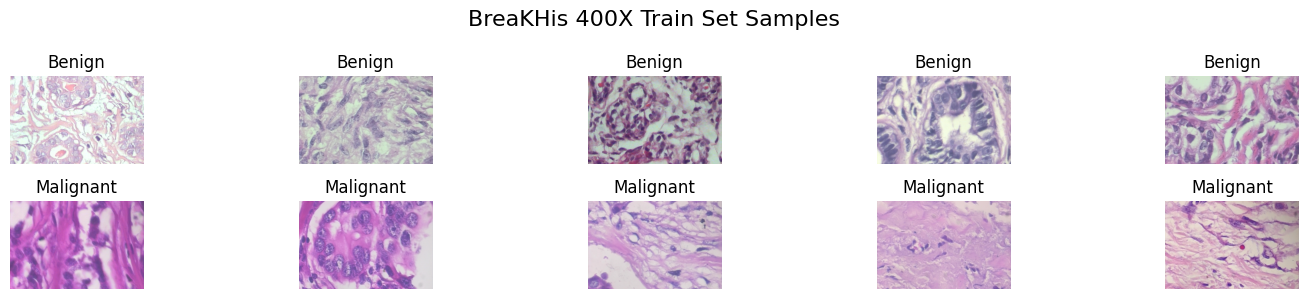

In [ ]:
benign_path = os.path.join(image_root, 'train', 'benign')
malignant_path = os.path.join(image_root, 'train', 'malignant')

benign_imgs = random.sample(os.listdir(benign_path), 5)
malignant_imgs = random.sample(os.listdir(malignant_path), 5)

# Plot benign
plt.figure(figsize=(15, 3))
for i, fname in enumerate(benign_imgs):
    img = Image.open(os.path.join(benign_path, fname))
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title("Benign")
    plt.axis("off")

# Plot malignant
for i, fname in enumerate(malignant_imgs):
    img = Image.open(os.path.join(malignant_path, fname))
    plt.subplot(2, 5, i+6)
    plt.imshow(img)
    plt.title("Malignant")
    plt.axis("off")

plt.suptitle("BreaKHis 400X Train Set Samples", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
sizes = Counter()
modes = Counter()

for split in ['train', 'test']:
    for cls in ['benign', 'malignant']:
        folder = os.path.join(image_root, split, cls)
        for fname in os.listdir(folder):
            if fname.endswith('.png'):
                img_path = os.path.join(folder, fname)
                try:
                    img = Image.open(img_path)
                    sizes[img.size] += 1
                    modes[img.mode] += 1
                except Exception as e:
                    print(f"Could not read image: {img_path} — {e}")

print("Image Sizes (Full Dataset):", sizes)
print("Image Modes (Full Dataset):", modes)

Image Sizes (Full Dataset): Counter({(700, 460): 1680, (700, 456): 13})
Image Modes (Full Dataset): Counter({'RGB': 1693})


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),           # Resize to 224x224
    transforms.ToTensor(),                   # Convert to [0, 1] tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet mean
                         std=[0.229, 0.224, 0.225])    # ImageNet std
])

In [ ]:
train_dir = os.path.join(image_root, 'train')
test_dir = os.path.join(image_root, 'test')

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

#dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# View shape of a sample batch
images, labels = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


In [ ]:
class BaseLineCNN(nn.Module):
    def __init__(self):
        super(BaseLineCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # (B, 3, 224, 224) → (B, 16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # (B, 16, 112, 112)

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # → (B, 32, 112, 112)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # → (B, 32, 56, 56)

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # → (B, 64, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                          # → (B, 64, 28, 28)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),                 # → (B, 64*28*28)
            nn.Linear(64*28*28, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),            # Binary output
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc(x)
        return x

In [ ]:
model = BaseLineCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    history = {"loss": [], "acc": []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        history["loss"].append(epoch_loss)
        history["acc"].append(epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    return history

In [ ]:
train_model(model, train_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Loss: 0.5726, Accuracy: 0.7674
Epoch 2/5, Loss: 0.4061, Accuracy: 0.8476
Epoch 3/5, Loss: 0.3751, Accuracy: 0.8563
Epoch 4/5, Loss: 0.3286, Accuracy: 0.8789
Epoch 5/5, Loss: 0.2945, Accuracy: 0.8894


{'loss': [0.5726100353829121,
  0.4061132859477598,
  0.3751127301400547,
  0.3285954695856945,
  0.294460610853255],
 'acc': [0.7674216027874564,
  0.8475609756097561,
  0.8562717770034843,
  0.8789198606271778,
  0.8893728222996515]}

In [ ]:
def plot_history(history):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(10, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["loss"], 'b-o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["acc"], 'g-o')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

Epoch 1/5, Loss: 0.2878, Accuracy: 0.8876
Epoch 2/5, Loss: 0.3520, Accuracy: 0.8606
Epoch 3/5, Loss: 0.2835, Accuracy: 0.8972
Epoch 4/5, Loss: 0.2719, Accuracy: 0.8929
Epoch 5/5, Loss: 0.2291, Accuracy: 0.9120


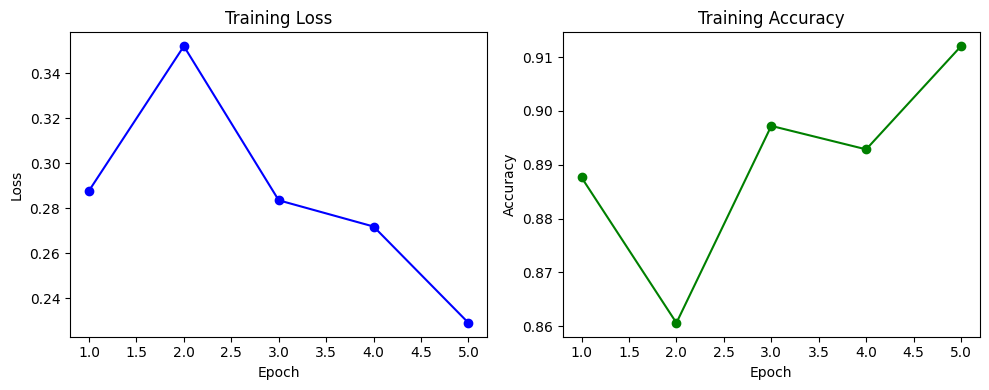

In [ ]:
history = train_model(model, train_loader, criterion, optimizer, num_epochs=5)
plot_history(history)

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            preds = (outputs > 0.5).float()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Test Accuracy: {correct / total:.4f}")

In [ ]:
evaluate_model(model, test_loader)

Test Accuracy: 0.8312


In [ ]:
def evaluate_with_confusion(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            preds = (outputs > 0.5).float()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true).astype(int).flatten()
    y_pred = np.array(y_pred).astype(int).flatten()

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))

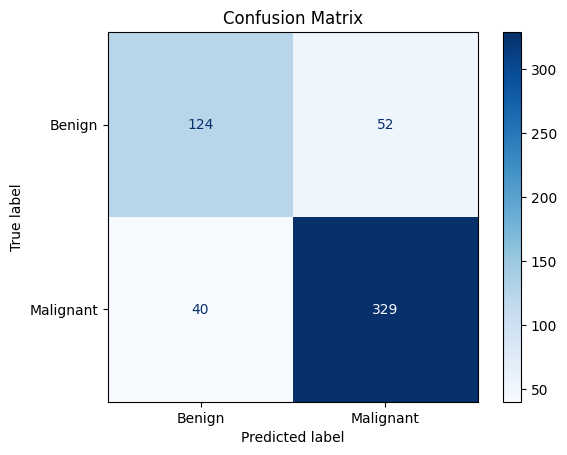

Classification Report:
              precision    recall  f1-score   support

      Benign       0.76      0.70      0.73       176
   Malignant       0.86      0.89      0.88       369

    accuracy                           0.83       545
   macro avg       0.81      0.80      0.80       545
weighted avg       0.83      0.83      0.83       545



In [ ]:
evaluate_with_confusion(model, test_loader)